# Cell label transfer on PEIVI mappiing space

Following the general tutorial on reference mapping, here we show using ``EpiPack`` for label transfer. We use the mapped embeddings from ``ref.obsm['z_ref']`` and ``query.obsm['z_ref']``, and apply the EpiPack classifier to perform cell label transfer.

In [2]:
## load epipack package

# !pip install --upgrade epipackpy
import scanpy as sc
import numpy as np
import pandas as pd

import epipackpy as epk
print(epk.__version__)

1.0.1dev4


In [3]:
## load ref and query
ref = sc.read_h5ad("tutorial_reference.h5ad")
query = sc.read_h5ad("tutorial_query.h5ad")

/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


### Label encoding

Before running the model, we suggest use ``sklearn LabelEncoder`` module to encode the ground truth label set in the reference. 

In [6]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(ref.obs.cell_type_new)

### Classifier training

In [7]:
clf = epk.ml.Classifier(ref_latent_emb=ref.obsm['z_ref'], ref_label=y, hidden_num=64, batchnorm=False)
clf.train_model(nepochs=100)

- Classifier initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Classifier intialization completed.


Epochs: 100%|██████████| 100/100 [01:36<00:00,  1.04it/s, loss_inner_val=0.0169, loss_inter_val=0.00535]


You can get the predicted from the trained classifier. This classifier can also be saved by ``pickle`` for future using.

In [9]:
result, _ = clf.get_z(query.obsm['z_query'])
querylabel = le.inverse_transform(result)

query.obs['predicted_label'] = querylabel

We visualize the predicted label below. 

/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/pynndescent/pynndescent_.py:358: NumbaPendingDeprecationWarning: The 'old_style' error capturing is deprecated and will be replaced by `new_style` in a future release.
  nn_descent_internal_low_memory_parallel(
/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/pynndescent/pynndescent_.py:358: NumbaPendingDeprecationWarning: The 'old_style' error capturing is deprecated and will be replaced by `new_style` in a future release.
  nn_descent_internal_low_memory_parallel(
/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/pynndescent/pynndescent_.py:370: NumbaPendingDeprecationWarning: The 'old_style' error capturing is deprecated and will be replaced by `new_style` in a future release.
  nn_descent_internal_high_memory_parallel(
/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/pynndescent/pynndescent_.py:370: NumbaPendingDeprecationWarning: The 'old_style' e

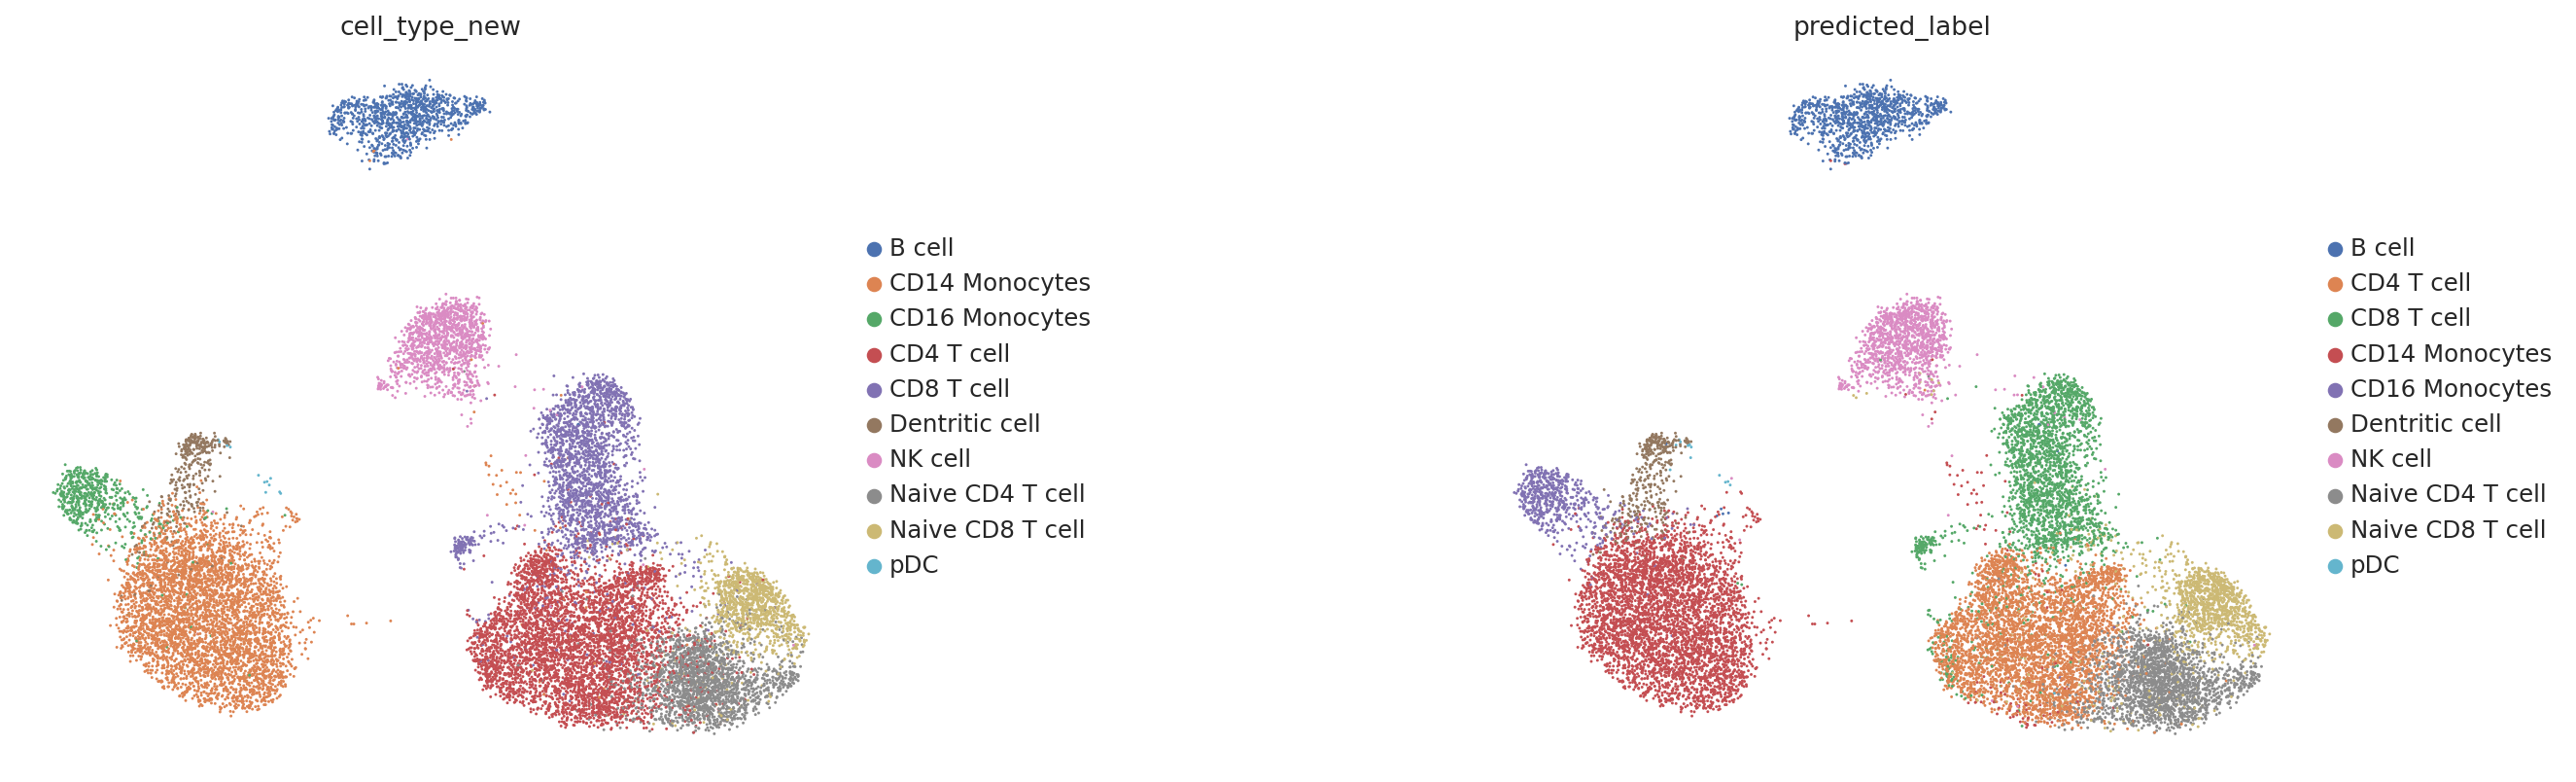

In [11]:
import seaborn as sns

sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()

sc.pp.neighbors(query, n_neighbors=50, use_rep='z_query')
sc.tl.umap(query)
#sc.tl.leiden(tmp, resolution=1.5)
sc.pl.umap(query, color=['cell_type_new', 'predicted_label'], ncols=2, wspace=0.6)

We can observe that the predicted labels and the ground truth almost completely overlap. Next, we perform a quantitative analysis to evaluate the performance of the EpiPack classifier.

In [12]:
from sklearn.metrics import f1_score

print("Macro:", f1_score(query.obs['cell_type_new'], query.obs['predicted_label'], average='macro'))
print("Micro:", f1_score(query.obs['cell_type_new'], query.obs['predicted_label'], average='micro'))
print("Weighted:", f1_score(query.obs['cell_type_new'], query.obs['predicted_label'], average='weighted'))

Macro: 0.8846567575111273
Micro: 0.920841741135774
Weighted: 0.9215123392897806


Now we can observe EpiPack’s performance using a confusion matrix.

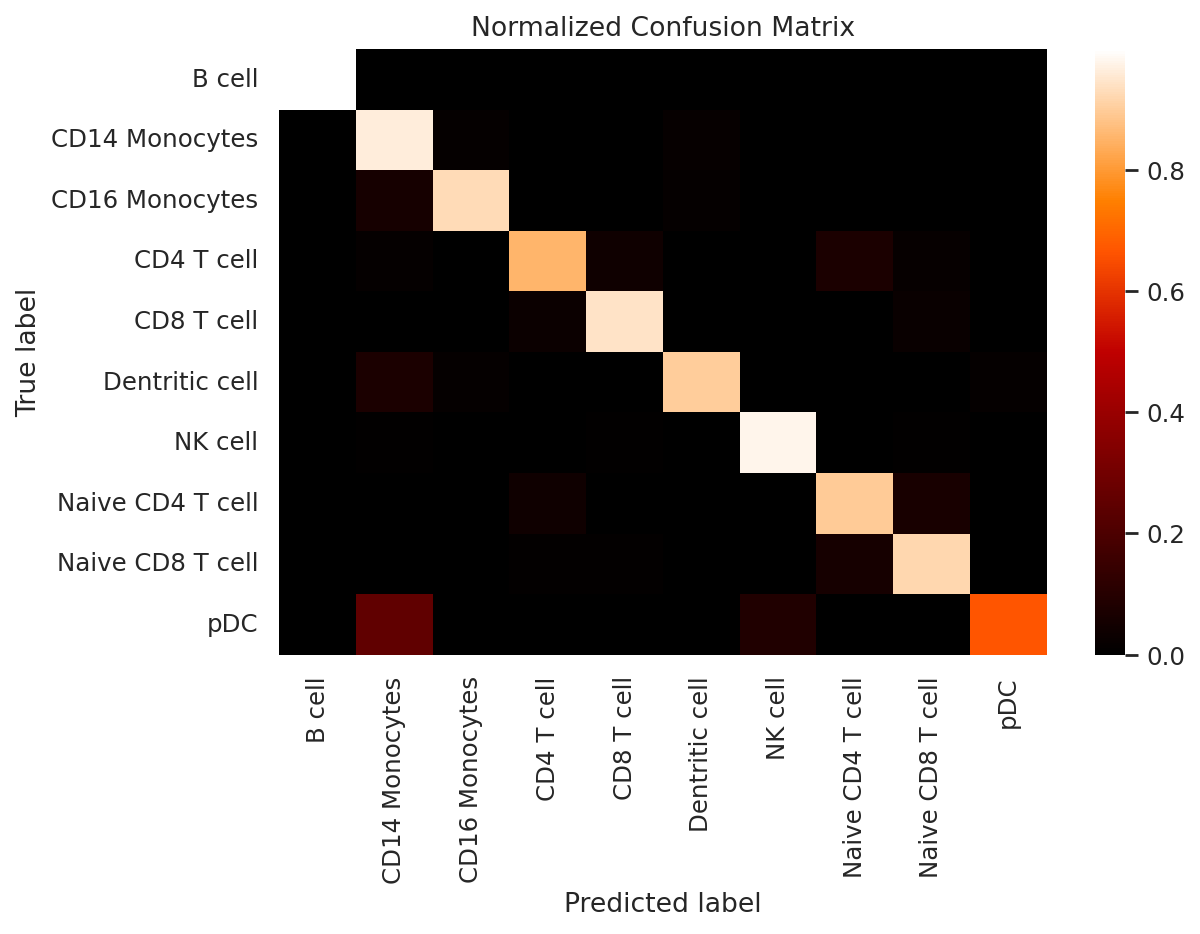

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

true_labels = query.obs['cell_type_new']
pred_labels = query.obs['predicted_label']

cm = confusion_matrix(true_labels, pred_labels, labels=np.unique(true_labels))
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_norm,
            annot=False, fmt=".2f", cmap="gist_heat",
            xticklabels=np.unique(true_labels),
            yticklabels=np.unique(true_labels))
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Normalized Confusion Matrix")
plt.tight_layout()
plt.show()